# Likelihood Analysis with Python

The python likelihood tools are a very powerful set of analysis tools that expand upon the command line tools provided with the Fermi Science Tools package. Not only can you perform all of the same likelihood analysis with the python tools that you can with the standard command line tools but you can directly access all of the model parameters.  You can more easily script a standard analysis like light curve generation.  There are also a few things built into the python tools that are not available from the command line like the calculation of upper limits.

There are many [user contributed packages](https://fermi.gsfc.nasa.gov/ssc/data/analysis/user/) built upon the python backbone of the Science Tools and we are going to highlight and use a few of them in this tutorial.

This sample analysis will look at 2 years of data for the object 3C 279, which is a relatively birght example of a type of Active Galactic Nucleus (AGN) known as a blazar. At certain points we will refer to this article as well as the [Cicerone](https://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/). This tutorial is based on the "[Binned Likelihood Tutorial](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/binned_likelihood_tutorial.html)" Analysis Thread, which is hosted on the Fermi Science Support Center website. 

This tutorial assumes you have the most recent [ScienceTools](https://fermi.gsfc.nasa.gov/ssc/data/analysis/software/) installed. We will also make significant use of python, so you might want to familiarize yourself with python (there's a beginner's guide at http://wiki.python.org/moin/BeginnersGuide. This tutorial also assumes that you've gone through the non-python based [unbinned likelihood](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/likelihood_tutorial.html) thread. Running through this notebook should take several hours to complete (depending on your computer's speed) if you do everything but there are some steps you can skip along the way which would shorten that.

> **Note:** This tutorial is generated from a [jupyter notebook](https://github.com/kialio/FSSC-Docs/blob/master/Threads/Python/python_tutorial.ipynb) which you can download and run yourself (the prefereed method). You can also run individual commands listed on this page.  If you do that, be aware that some commands must be executed in an ipython/jupyter environment.

## Get the Data

For this thread the original data were extracted from the [LAT data server](https://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/LATDataQuery.cgi) with the following selections (these selections are similar to those in the paper):

* Search Center (RA,Dec) = (193.98, -5.82)
* Radius = 15 degrees
* Start Time (MET) = 239557417 seconds (2008-08-04 T15:43:37)
* Stop Time (MET) = 302572802 seconds (2010-08-04 T00:00:00)
* Minimum Energy = 100 MeV
* Maximum Energy = 500000 MeV

We've provided direct links to the event files as well as the spacecraft data file if you don't want to take the time to use the download server. For more information on how to download LAT data please see the [Extract LAT Data](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/explore_latdata.html) tutorial.

* [L181126210218F4F0ED2738_PH00.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/BinnedLikelihood/L181126210218F4F0ED2738_PH00.fits)
* [L181126210218F4F0ED2738_PH01.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/BinnedLikelihood/L181126210218F4F0ED2738_PH01.fits)
* [L181126210218F4F0ED2738_PH02.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/BinnedLikelihood/L181126210218F4F0ED2738_PH02.fits)
* [L181126210218F4F0ED2738_PH03.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/BinnedLikelihood/L181126210218F4F0ED2738_PH03.fits)
* [L181126210218F4F0ED2738_PH04.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/BinnedLikelihood/L181126210218F4F0ED2738_PH04.fits)
* [L181126210218F4F0ED2738_PH05.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/BinnedLikelihood/L181126210218F4F0ED2738_PH05.fits)
* [L181126210218F4F0ED2738_PH06.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/BinnedLikelihood/L181126210218F4F0ED2738_PH06.fits)
* [L181126210218F4F0ED2738_SC00.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/BinnedLikelihood/L181126210218F4F0ED2738_SC00.fits)

Make a working directory and then download all of the files into that directory.

In [1]:
!mkdir working

In [2]:
import urllib.request

In [3]:
url_base = "https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/BinnedLikelihood/"
datafiles = ["L181126210218F4F0ED2738_PH00.fits", 
             "L181126210218F4F0ED2738_PH01.fits",
             "L181126210218F4F0ED2738_PH02.fits",
             "L181126210218F4F0ED2738_PH03.fits",
             "L181126210218F4F0ED2738_PH04.fits",
             "L181126210218F4F0ED2738_PH05.fits",
             "L181126210218F4F0ED2738_PH06.fits",
             "L181126210218F4F0ED2738_SC00.fits"]

In [4]:
for datafile in datafiles:
    urllib.request.urlretrieve(url_base+datafile,"working/"+datafile)

In [5]:
ls working/

L181126210218F4F0ED2738_PH00.fits  L181126210218F4F0ED2738_PH04.fits
L181126210218F4F0ED2738_PH01.fits  L181126210218F4F0ED2738_PH05.fits
L181126210218F4F0ED2738_PH02.fits  L181126210218F4F0ED2738_PH06.fits
L181126210218F4F0ED2738_PH03.fits  L181126210218F4F0ED2738_SC00.fits


Now, you'll first need to make a file list with the names of your input event files:

In [6]:
ls -1 working/*PH*.fits > binned_events.txt

We can rename the spacecraft file to make it easier to work with:

In [7]:
mv working/L181126210218F4F0ED2738_SC00.fits working/3C279_SC.fits

In the following analysis we've assumed that you've named your list of data files binned_events.list and the spacecraft file 3C279_SC.fits.

In [8]:
#Let's get a timestamp, so we can see how long this takes to run on your machine.
!date

Tue Dec 15 22:20:21 EST 2020


## Perform Event Selections

The gt_apps module provides methods to call the various FermiTools from within python. 

In [9]:
import gt_apps as my_apps

The python object for gtselect is called filter and we first need to set all of its options. It might not seem that convenient to do it this way (as opposed to entering the options via the command line) but it's really nice once you start building up scripts and reading back options and such. For example, generating a light curve entails running the likelihood analysis for each datapoint. It'll be much easier to do all of that within python and change the tmin and tmax in an iterative fashion. Note that these python objects are just wrappers for the standalone tools so if you want any information on their options, see the corresponding [documentation](/ssc/data/analysis/scitools/references.html) for the standalone tool.

In [10]:
my_apps.filter['evclass'] = 128
my_apps.filter['evtype'] = 3
my_apps.filter['ra'] = 'INDEF'
my_apps.filter['dec'] = 'INDEF'
my_apps.filter['rad'] = 'INDEF'
my_apps.filter['emin'] = 100
my_apps.filter['emax'] = 500000
my_apps.filter['zmax'] = 90
my_apps.filter['tmin'] = 'INDEF'
my_apps.filter['tmax'] = 'INDEF'
my_apps.filter['infile'] = '@binned_events.txt'
my_apps.filter['outfile'] = 'working/3C279_binned_filtered.fits'

Now, run gtselect:

In [11]:
my_apps.filter.run()

time -p gtselect infile=@binned_events.txt outfile=working/3C279_binned_filtered.fits ra="INDEF" dec="INDEF" rad="INDEF" tmin="INDEF" tmax="INDEF" emin=100.0 emax=500000.0 zmin=0.0 zmax=90.0 evclass=128 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 3.95
user 3.42
sys 0.28


Next, you need to run gtmktime. This is accessed within python via the maketime object:

In [12]:
my_apps.maketime['scfile'] = 'working/3C279_SC.fits'
my_apps.maketime['filter'] = '(DATA_QUAL>0)&&(LAT_CONFIG==1)'
my_apps.maketime['roicut'] = 'no'
my_apps.maketime['evfile'] = 'working/3C279_binned_filtered.fits'
my_apps.maketime['outfile'] = 'working/3C279_binned_gti.fits'
my_apps.maketime.run()

time -p gtmktime scfile=working/3C279_SC.fits sctable="SC_DATA" filter="(DATA_QUAL>0)&&(LAT_CONFIG==1)" roicut=no evfile=working/3C279_binned_filtered.fits evtable="EVENTS" outfile="working/3C279_binned_gti.fits" apply_filter=yes overwrite=no header_obstimes=yes tstart=0.0 tstop=0.0 gtifile="default" chatter=2 clobber=yes debug=no gui=no mode="ql"
real 21.44
user 20.43
sys 0.76


We're using the most conservative and most commonly used cuts described in detail in the [Cicerone](http://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_Likelihood/Exposure.html).

## Create a 3-D (binned) counts map

For binned likelihood analysis, the data input is a three-dimensional counts map with an energy axis, called a counts cube. The gtbin tool performs this task as well, by using the CCUBE option.

In [13]:
my_apps.counts_map['algorithm'] = 'CCUBE'
my_apps.counts_map['evfile'] = 'working/3C279_binned_gti.fits'
my_apps.counts_map['scfile'] = 'none'
my_apps.counts_map['outfile'] = 'working/3C279_binned_ccube.fits'
my_apps.counts_map['nxpix'] = 100
my_apps.counts_map['nypix'] = 100
my_apps.counts_map['binsz'] = 0.2
my_apps.counts_map['coordsys'] = 'CEL'
my_apps.counts_map['xref'] = 193.98
my_apps.counts_map['yref'] = -5.82
my_apps.counts_map['axisrot'] = 0
my_apps.counts_map['proj'] = 'AIT'
my_apps.counts_map['ebinalg'] = 'LOG'
my_apps.counts_map['emin'] = 100
my_apps.counts_map['emax'] = 500000
my_apps.counts_map['enumbins'] = 37
my_apps.counts_map.run()

time -p gtbin evfile=working/3C279_binned_gti.fits scfile=none outfile=working/3C279_binned_ccube.fits algorithm="CCUBE" ebinalg="LOG" emin=100.0 emax=500000.0 enumbins=37 denergy=0.0 ebinfile=NONE tbinalg="LIN" tstart=239557517.0 tstop=255335817.0 dtime=86400.0 tbinfile=NONE snratio=0.0 lcemin=0.0 lcemax=0.0 nxpix=100 nypix=100 binsz=0.2 coordsys="CEL" xref=193.98 yref=-5.82 axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"
This is gtbin version HEAD
gtbin: WARNING: No spacecraft file: EXPOSURE keyword will be set equal to ontime.
real 0.51
user 0.43
sys 0.05


## Livetime Cubes and Exposure Maps

The next two steps pre-compute the livetime over the whole sky and the exposure map over your are of intere, respectively. Doing this in advance of running the likelihood tool will save a significant amount of time when running the gtlike task itself. This can be usefull if you wish to re-do the likelihood analysis multiple times (after, say, adjusting the model inputs or trying out different fitting algorithms). So, let's go ahead and do these "extra" steps.

### Livetime Cube

We can pre-compute the livetime as a function of sky position and off-axis angle, which will speed up the likelihood analysis. This step will take approximately 30 minutes to complete, so this may be a good time to respond to that email you've been thinking about.

In [14]:
my_apps.expCube['evfile'] = 'working/3C279_binned_gti.fits'
my_apps.expCube['scfile'] = 'working/3C279_SC.fits'
my_apps.expCube['outfile'] = 'working/3C279_ltCube.fits'
my_apps.expCube['zmax'] = 90
my_apps.expCube['dcostheta'] = 0.025
my_apps.expCube['binsz'] = 1
my_apps.expCube.run()

time -p gtltcube evfile="working/3C279_binned_gti.fits" evtable="EVENTS" scfile=working/3C279_SC.fits sctable="SC_DATA" outfile=working/3C279_ltCube.fits dcostheta=0.025 binsz=1.0 phibins=0 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=90.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
Working on file working/3C279_SC.fits
.....................!
real 1838.17
user 1833.83
sys 2.20


### Exposure Map

This next step will apply the livetime calculated in the previous step to your region of interest. This tool generates a binned exposure map, an accounting of the exposure at each position in the sky, that are a required input to the likelihood process. 

The LAT has a very large Point Spread Function (PSF), especially at low energies. In order to account for contributions from sources outside our ROI we need to make the exposure map cover a larger area on the sky, equal to the ROI plus 10 degrees.

In [15]:
from GtApp import GtApp
expCube2= GtApp('gtexpcube2','Likelihood')

In [16]:
expCube2['infile'] = 'working/3C279_ltCube.fits'
expCube2['cmap'] = 'none'
expCube2['outfile'] = 'working/3C279_BinnedExpMap.fits'
expCube2['irfs'] = 'P8R3_SOURCE_V3'
expCube2['evtype'] = '3'
expCube2['nxpix'] = 1800
expCube2['nypix'] = 900
expCube2['binsz'] = 0.2
expCube2['coordsys'] = 'CEL'
expCube2['xref'] = 193.98
expCube2['yref'] = -5.82
expCube2['axisrot'] = 0
expCube2['proj'] = 'AIT'
expCube2['ebinalg'] = 'LOG'
expCube2['emin'] = 100
expCube2['emax'] = 500000
expCube2['enumbins'] = 37
expCube2.run()

time -p gtexpcube2 infile=working/3C279_ltCube.fits cmap=none outfile=working/3C279_BinnedExpMap.fits irfs="P8R3_SOURCE_V3" evtype=3 edisp_bins=0 nxpix=1800 nypix=900 binsz=0.2 coordsys="CEL" xref=193.98 yref=-5.82 axisrot=0.0 proj="AIT" ebinalg="LOG" emin=100.0 emax=500000.0 enumbins=37 ebinfile="NONE" hpx_ordering_scheme="RING" hpx_order=6 bincalc="EDGE" ignorephi=no thmax=180.0 thmin=0.0 table="EXPOSURE" chatter=2 clobber=yes debug=no mode="ql"
Computing binned exposure map....................!
Using evtype=3 (i.e., FRONT/BACK irfs)
real 130.87
user 128.80
sys 1.74


## Generate XML Model File

We need to create an XML file with all of the sources of interest within the Region of Interest (ROI) of 3C 279 so we can correctly model the background. For more information on the format of the model file and how to create one, see the [likelihood analysis](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/likelihood_tutorial.html#createSourceModel) tutorial. We'll use the user contributed tool `make4FGLxml.py` to create a model file based on the LAT 4-year LAT catalog. You'll need to download the FITS version of this file at [http://fermi.gsfc.nasa.gov/ssc/data/access/lat/4yr_catalog/](http://fermi.gsfc.nasa.gov/ssc/data/access/lat/4yr_catalog/) and get the [make4FGLxml.py](https://fermi.gsfc.nasa.gov/ssc/data/analysis/user/python3/make4FGLxml.py) tool from the [user contributed software](http://fermi.gsfc.nasa.gov/ssc/data/analysis/user/) page and put them both in your working directory. Also make sure you have the most recent galactic diffuse and isotropic model files which can be found at [http://fermi.gsfc.nasa.gov/ssc/data/access/lat/BackgroundModels.html](http://fermi.gsfc.nasa.gov/ssc/data/access/lat/BackgroundModels.html). In the following we assume that you have the galactic diffuse and isotropic files in your FermiTools install and we just make local symbolic links.

In [17]:
urllib.request.urlretrieve('https://fermi.gsfc.nasa.gov/ssc/data/analysis/user/python3/make4FGLxml.py','make4FGLxml.py')

('make4FGLxml.py', <http.client.HTTPMessage at 0x105f297d0>)

In [18]:
urllib.request.urlretrieve('https://fermi.gsfc.nasa.gov/ssc/data/access/lat/10yr_catalog/gll_psc_v26.xml','working/gll_psc_v26.xml')

('working/gll_psc_v26.xml', <http.client.HTTPMessage at 0x105f13150>)

In [19]:
!ln -s $FERMI_DIR/refdata/fermi/galdiffuse/iso_P8R3_SOURCE_V3_v1.txt working/iso_P8R3_SOURCE_V3_v1.txt

In [20]:
!ln -s $FERMI_DIR/refdata/fermi/galdiffuse/gll_iem_v07.fits working/gll_iem_v07.fits

In [21]:
ls working

3C279_BinnedExpMap.fits            L181126210218F4F0ED2738_PH02.fits
3C279_SC.fits                      L181126210218F4F0ED2738_PH03.fits
3C279_binned_ccube.fits            L181126210218F4F0ED2738_PH04.fits
3C279_binned_filtered.fits         L181126210218F4F0ED2738_PH05.fits
3C279_binned_gti.fits              L181126210218F4F0ED2738_PH06.fits
3C279_ltCube.fits                  gll_iem_v07.fits@
L181126210218F4F0ED2738_PH00.fits  gll_psc_v26.xml
L181126210218F4F0ED2738_PH01.fits  iso_P8R3_SOURCE_V3_v1.txt@


Now that we have all of the files we need, you can generate your model file:

In [22]:
from make4FGLxml import *

This is make4FGLxml_py3 version 01r06.  This version is designed to be compatible with python3.
The default diffuse model files and names are for pass 8 and 4FGL and assume you have v11r5p3 of the Fermi Science Tools or higher.
The default isotropic template is now for P8R3_SOUCE_V3 IRFs.


In [23]:
mymodel = srcList('working/gll_psc_v26.xml','working/3C279_binned_gti.fits','working/3C279_model.xml')

In [24]:
mymodel.makeModel('working/gll_iem_v07.fits', 
                  'working/gll_iem_v07.fits', 
                  'working/iso_P8R3_SOURCE_V3_v1.txt', 
                  'working/iso_P8R3_SOURCE_V3_v1')

Creating file and adding sources from 4FGL
Added 241 point sources and 0 extended sources


You can open the model file with your favorite text editor to have a look at it. In the 4FGL catalog, 3C 279 is referred to as "4FGL J1256.1-0547". The model for this source is reproduced below. Note the parameters that say "free="1"" - the "1" indicates that these parameters will be left free during the likelihood analysis, which will also be true for several of the other sources in our ROI.

### Source Map

The [gtsrcmaps](https://raw.githubusercontent.com/fermi-lat/fermitools-fhelp/master/gtsrcmaps.txt) tool creates model counts maps for use with the binned likelihood analysis. To do this, it takes each source spectrum in the XML model, multiplies it by the exposure at the source position, and convolves that exposure with the effective PSF.

In [25]:
my_apps.srcMaps['expcube'] = 'working/3C279_ltCube.fits'
my_apps.srcMaps['cmap'] = 'working/3C279_binned_ccube.fits'
my_apps.srcMaps['srcmdl'] = 'working/3C279_model.xml'
my_apps.srcMaps['outfile'] = 'working/3C279_binned_srcmaps.fits'
my_apps.srcMaps['bexpmap'] = 'working/3C279_BinnedExpMap.fits'
my_apps.srcMaps['irfs'] = 'CALDB'
my_apps.srcMaps.run()

time -p gtsrcmaps scfile= sctable="SC_DATA" expcube=working/3C279_ltCube.fits cmap=working/3C279_binned_ccube.fits srcmdl=working/3C279_model.xml bexpmap=working/3C279_BinnedExpMap.fits wmap=none outfile=working/3C279_binned_srcmaps.fits irfs="CALDB" evtype="INDEF" convol=yes resample=yes rfactor=2 minbinsz=0.1 ptsrc=yes psfcorr=yes emapbnds=yes edisp_bins=0 copyall=no chatter=2 clobber=yes debug=no gui=no mode="ql"
Generating SourceMap for 4FGL J1118.2-0415 38....................!
Generating SourceMap for 4FGL J1118.6-1235 38....................!
Generating SourceMap for 4FGL J1119.9-1007 38....................!
Generating SourceMap for 4FGL J1121.3-0011 38....................!
Generating SourceMap for 4FGL J1121.4-0553 38....................!
Generating SourceMap for 4FGL J1122.0-0231 38....................!
Generating SourceMap for 4FGL J1122.5-1440 38....................!
Generating SourceMap for 4FGL J1124.1-1203 38....................!
Generating SourceMap for 4FGL J1124.6-0809 3

Generating SourceMap for 4FGL J1243.7+1727 38....................!
Generating SourceMap for 4FGL J1243.9-0218 38....................!
Generating SourceMap for 4FGL J1244.5+1616 38....................!
Generating SourceMap for 4FGL J1245.8+0232 38....................!
Generating SourceMap for 4FGL J1246.3+0112 38....................!
Generating SourceMap for 4FGL J1246.7-2548 38....................!
Generating SourceMap for 4FGL J1249.2-2809 38....................!
Generating SourceMap for 4FGL J1249.3-0545 38....................!
Generating SourceMap for 4FGL J1250.6+0217 38....................!
Generating SourceMap for 4FGL J1251.2+1039 38....................!
Generating SourceMap for 4FGL J1251.3-0201 38....................!
Generating SourceMap for 4FGL J1251.3-1719 38....................!
Generating SourceMap for 4FGL J1252.7-2520 38....................!
Generating SourceMap for 4FGL J1253.8+0327 38....................!
Generating SourceMap for 4FGL J1254.2-2205 38.................

Generating SourceMap for 4FGL J1429.8-0739 38....................!
Generating SourceMap for working/gll_iem_v07.fits 38....................!
Generating SourceMap for working/iso_P8R3_SOURCE_V3_v1 38....................!
real 501.95
user 482.46
sys 17.98


## Compute the diffuse source responses.

The diffuse source responses tell the likelihood fitter what the expected contribution would be for each diffuse source, given the livetime associated with each event. The source model XML file must contain all of the diffuse sources to be fit. The [gtdiffrsp](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtdiffrsp.txt) tool will add one column to the event data file for each diffuse source. The diffuse response depends on the instrument response function (IRF), which must be in agreement with the selection of events, i.e. the event class and event type we are using in our analysis. Since we are using SOURCE class, CALDB should use the P8R3_SOURCE_V3 IRF for this tool.

If the diffuse responses are not precomputed using [gtdiffrsp](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtdiffrsp.txt), then the [gtlike](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtlike.txt) tool will compute them at runtime (during the next step). However, as this step is very computationally intensive (often taking ~hours to complete), and it is very likely you will need to run [gtlike](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtlike.txt) more than once, it is probably wise to precompute these quantities.


In [26]:
my_apps.diffResps['evfile'] = 'working/3C279_binned_gti.fits'
my_apps.diffResps['scfile'] = 'working/3C279_SC.fits'
my_apps.diffResps['srcmdl'] = 'working/3C279_model.xml'
my_apps.diffResps['irfs'] = 'CALDB'
my_apps.diffResps.run()

time -p gtdiffrsp evfile=working/3C279_binned_gti.fits evtable="EVENTS" scfile=working/3C279_SC.fits sctable="SC_DATA" srcmdl=working/3C279_model.xml irfs="CALDB" evclsmin=0 evclass="INDEF" evtype="INDEF" convert=no chatter=2 clobber=no debug=no gui=no mode="ql"
adding source working/gll_iem_v07.fits
adding source working/iso_P8R3_SOURCE_V3_v1
Working on...
working/3C279_binned_gti.fits.....................!
real 8569.05
user 8553.75
sys 6.79


## Run the Likelihood Analysis

It's time to actually run the likelihood analysis now. First, you need to import the pyLikelihood module and then the UnbinnedAnalysis functions (there's also a binned analysis module that you can import to do [binned likelihood analysis](https://fermi.gsfc.nasa.gov//ssc/data/analysis/scitools/binned_likelihood_tutorial.html) which behaves almost exactly the same as the unbinned analysis module).  For more details on the pyLikelihood module, check out the [pyLikelihood Usage Notes](https://fermi.gsfc.nasa.gov//ssc/data/analysis/scitools/python_usage_notes.html).

In [27]:
!ls working/

3C279_BinnedExpMap.fits           L181126210218F4F0ED2738_PH01.fits
3C279_SC.fits                     L181126210218F4F0ED2738_PH02.fits
3C279_binned_ccube.fits           L181126210218F4F0ED2738_PH03.fits
3C279_binned_filtered.fits        L181126210218F4F0ED2738_PH04.fits
3C279_binned_gti.fits             L181126210218F4F0ED2738_PH05.fits
3C279_binned_srcmaps.fits         L181126210218F4F0ED2738_PH06.fits
3C279_ltCube.fits                 gll_iem_v07.fits
3C279_model.xml                   gll_psc_v26.xml
L181126210218F4F0ED2738_PH00.fits iso_P8R3_SOURCE_V3_v1.txt


In [28]:
import pyLikelihood
from BinnedAnalysis import *
obs = BinnedObs(srcMaps='working/3C279_binned_srcmaps.fits',
                binnedExpMap='working/3C279_BinnedExpMap.fits',
                expCube='working/3C279_ltCube.fits',
                irfs='CALDB')
like = BinnedAnalysis(obs,'working/3C279_model.xml',optimizer='NewMinuit')

By now, you'll have two objects, 'obs', an UnbinnedObs object and like, an UnbinnedAnalysis object. You can view these objects attributes and set them from the command line in various ways. For example:

In [29]:
print(obs)

Source maps: working/3C279_binned_srcmaps.fits
Exposure cube: working/3C279_ltCube.fits
Exposure map: working/3C279_BinnedExpMap.fits
IRFs: CALDB


In [30]:
print(like)

Source maps: working/3C279_binned_srcmaps.fits
Exposure cube: working/3C279_ltCube.fits
Exposure map: working/3C279_BinnedExpMap.fits
IRFs: CALDB
Source model file: working/3C279_model.xml
Optimizer: NewMinuit


There are a lot of attributes and here you start to see the power of using pyLikelihood since you'll be able (once the fit is done) to access any of these attributes directly within python and use them in your own scripts.

Now, we're ready to do the actual fit. This next step will take approximately 10 minutes to complete.  We're doing something a bit fancy here.  We're getting the minimizating object (and calling it `likeobj`) from the logLike object so that we can access it later.  We pass this object to the fit routine so that it knows which fitting object to use.  We're also telling the code to calculate the
covariance matrix so we can get at the errors.

In [31]:
likeobj=pyLikelihood.NewMinuit(like.logLike)
like.fit(verbosity=0,covar=True,optObject=likeobj)

72593.89794181124

The number that is printed out here is the -log(Likelihood) of the total fit to the data. You can print the results of the fit by accessing like.model. You can also access the fit for a particular source by doing the following (the source name must match that in the XML model file).

In [32]:
like.model['4FGL J1256.1-0547']

4FGL J1256.1-0547
   Spectrum: LogParabola
422         norm:  1.386e+00  1.518e-02  0.000e+00  1.000e+02 ( 1.000e-10)
423        alpha:  2.293e+00  1.028e-02  0.000e+00  5.000e+00 ( 1.000e+00)
424         beta:  6.866e-01  6.540e-02 -5.000e+00  1.000e+01 ( 1.000e-01)
425           Eb:  5.537e-01  0.000e+00  1.000e-02  1.000e+02 ( 1.000e+03) fixed

The Test Statistic (TS) value is a useful quantity to record when evaluating likelihood results. A TS > 25 is generally considered a strong detection with a high likelihood of being real. 

In [36]:
like.Ts('4FGL J1256.1-0547')

29315.27972251101

You can plot the results of the fit by executing the plot command. The results are shown below:


Data  207751.0
srcName  1.1504089856783581
srcName  0.8788688981057069
srcName  0.15820582237595157
srcName  0.08109743641834478
srcName  2.549122407017949
srcName  0.2767968977519388
srcName  0.4958909457972051
srcName  0.20051919011898275
srcName  0.17708226027712862
srcName  0.3426429412482797
srcName  2.754296571959106
srcName  0.1824172436014473
srcName  2.7826608455110713
srcName  0.2888488572283987
srcName  0.2764626981104433
srcName  0.2542905757678804
srcName  4.108657368700294
srcName  0.07057590484918022
srcName  0.03347189061549695
srcName  2.2506870238087617
srcName  1.7344154603658009
srcName  0.003753050331835279
srcName  0.5387637828022851
srcName  0.700103020448729
srcName  0.2992937680808332
srcName  2.096307949009182
srcName  0.6266209677939509
srcName  9.050661290226904
srcName  1.7915784920471234
srcName  0.045931850792591
srcName  1.6161343742928487
srcName  2.6084321442857457
srcName  0.19703599394953045
srcName  22.535412245163425
srcName  9.899551839764582
srcN

/opt/miniconda3/envs/fermi/lib/python3.7/site-packages/fermitools/MPLPlot.py:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()
/opt/miniconda3/envs/fermi/lib/python3.7/site-packages/fermitools/MPLPlot.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


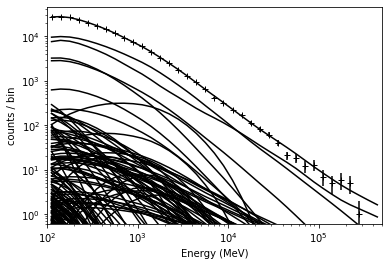

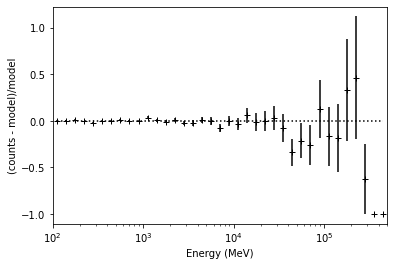

In [33]:
%matplotlib inline
like.plot()

The output of the plot function of the like BinnedAnalysis object shows:

* Top: the contribution of each of the objects in the model to the total model, and plots the data points on top.
* Bottom: the residuals of the likelihood fit to the data.Notice that the fit is poor in the second to last bin.

Now, check for convergence.

In [37]:
#print(likeobj.getRetCode())

If you get anything other than '0' here, than NewMinuit didn't converge. There are several reasons that we might not get convergance:

* The culprit is usually a parameter (or parameters) in the model that reach the limits set in the XML file. If this happens the minimizer cannot reach the formal minimum, and hence cannot calculate the curvature.
* Often the problem is with spectral shape parameters (PL index etc..), so simply freezing the shape of all spectral parameters to their values from the full time period (and certainly for weaker background sources) when fitting a shorter time period may solve the problem. Remember that the 3FGL catalog used a full 4 years of data and we're using a much shorter time period here
* Weak background sources are more likely to cause problems, so you could consider just freezing them completely (or removing them from the model). For example a background source from the catalog that is detected at TS~=25 in 2 years could cause convergence problems in a 1-month light curve, where it will often not be detectable at all.
* If there are no parameters at their limits, then increasing the overall convergence tolerance may help - try using a value of 1E-8 for the absolute tolerance.
* If that doesn't help then try to systematically simplify the model. Progressively freeze all sources, starting with those at the edge of the ROI in and moving in until you get a model simple enough for the minimizer to work reliably. For example if you are using a 10 degree ROI, you could start by freezing all background sources further than 7 degrees from the source of interest, and move to 5 degrees if that doesn't solve the problem.

In [35]:
!date

Wed Dec 16 02:19:54 EST 2020
